https://www.kaggle.com/teyang/twitter-disaster-eda-clean-lstm

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import re
import string

from sklearn.model_selection import train_test_split

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
df = pd.read_csv('train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
df.shape

(7613, 5)

In [4]:
# only keeping text features

In [5]:
df = df.drop(['id','keyword','location'], axis=1)

In [6]:
duplicate_dict = {}
for num, row in df[df['text'].duplicated()].iterrows():
    if row['text'] not in duplicate_dict:
        duplicate_dict[row['text']] = [row['target']]
    else:
        duplicate_dict[row['text']].append(row['target'])
duplicate_dict

opp_target = []
for k,v in duplicate_dict.items():
    if all(x == v[0] for x in v):
        pass
    else:
        opp_target.append(k)
index_list = []
for i in opp_target:
    for j in list(df[df['text'].str.contains(i)].index.values):
        index_list.append(j)

/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [7]:
df.shape

(7613, 2)

In [8]:
df = df.drop(np.array(index_list), axis=0)
df.shape

(7580, 2)

In [9]:
df = df.drop_duplicates(subset = 'text', keep='first') # we remove 1 of each of the remaining duplicate pairs
df.shape

(7493, 2)

In [10]:
def remove_hashtag(text):
    sep = '#'
    return text.split(sep, 1)[0]

In [11]:
df['text'] = df['text'].apply(lambda x: remove_hashtag(x))
df.head()

,text,target
0,Our Deeds are the Reason of this,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive",1
4,Just got sent this photo from Ruby,1


In [12]:
import spacy
nlp = spacy.load('en_core_web_sm')
import re
import string
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = ''.join([c for c in text if c not in string.punctuation])
    tokens = re.split('\W+', text)
    stop_words = stopwords.words('english') + ['u', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    text = ' '.join([word for word in tokens if word not in stop_words])
    text = nlp(text)
    text = ' '.join([word.lemma_ for word in text])
    return text

In [13]:
df['text'] = df['text'].apply(lambda x: clean_text(x))
df.head()

,text,target
0,deeds reason,1
1,forest fire near la ronge sask canada,1
2,resident ask shelter place notify officer evac...,1
3,people receive,1
4,get send photo ruby,1


### Splitting Data

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], 
                                                    df['target'], 
                                                    test_size=.1, 
                                                    random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6743,), (750,), (6743,), (750,))

In [15]:
X_train.str.split()

5782           [would, black, dude, antioch, would, riot]
6333    [rightway, build, structural, integrity, amp, ...
6856                       [butt, trauma, extraordinaire]
6181                                    [lets, goooooooo]
3687    [kosciusko, police, investigate, pedestrian, f...
                              ...                        
913     [chxrmingprince, jonesluna, bloody, hope, say,...
5282    [family, sue, legionnaire, family, affect, fat...
4040                                                   []
239     [annihilate, damascus, syrian, army, grind, û,...
5247    [refugio, oil, spill, may, costlier, big, proj...
Name: text, Length: 6743, dtype: object

### Tokenization

In [16]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000, oov_token=True)
tokenizer.fit_on_texts(X_train)

In [17]:
X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)

In [18]:
len(tokenizer.word_index)
# Shouldn't length = 5000??????

11976

### Padding

In [19]:
max_len_train=0
for i in X_train_tokens:
    if len(i) > max_len_train:
        max_len_train = len(i)
print(f'Max length of training: {max_len_train}')

Max length of training: 23


In [20]:
from keras.preprocessing.sequence import pad_sequences

X_train_pad = pad_sequences(X_train_tokens, padding='pre', maxlen=max_len_train)
X_test_pad = pad_sequences(X_test_tokens, padding='pre', maxlen=max_len_train)

### GloVe Embedding
https://github.com/stanfordnlp/GloVe  

download this zip which contains 4 files (glove.twitter.27B.zip)  
each of those files maps a word to different sized vectors.  
I chose 100d so the rest of my notebook uses 100 as a dimension so make sure to change that

In [21]:
!wget -q https://huggingface.co/stanfordnlp/glove/resolve/main/glove.twitter.27B.zip


In [22]:
! unzip glove.twitter.27B.zip

Archive:  glove.twitter.27B.zip
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  


In [23]:
glove_dict = {}
with open('glove.twitter.27B.100d.txt', 'r') as file:
    for line in file:
        val = line.split()
        word = val[0]
        glove_vec = val[1:]
        glove_dict[word] = np.array(glove_vec).astype(np.float64)
file.close()

In [24]:
vocab_size = len(tokenizer.word_index) + 1
glove_matrix = np.zeros((vocab_size, 100))  # change shape based on which glove file was used (25, 50, 100, 200)

for word, index in tokenizer.word_index.items():
    if index < vocab_size:
        vec = glove_dict.get(word)
        if vec is not None:
            glove_matrix[index] = vec

In [25]:
glove_matrix.shape

(11977, 100)

In [26]:
glove_matrix

array([[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [-0.11164  ,  0.35396  , -0.21636  , ..., -0.10389  ,  0.39103  ,
         0.0045548],
       ...,
       [-1.3365   , -0.63749  ,  0.2017   , ...,  0.96608  ,  0.73568  ,
        -0.4172   ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [-0.30358  ,  0.2915   ,  0.73429  , ..., -0.58555  ,  0.31957  ,
         0.31524  ]])

### Words Missing from GloVe model

In [27]:
np.where(~glove_matrix.any(axis=1))[0].shape

(3075,)

In [28]:
glove_matrix.shape

(11977, 100)

In [29]:
np.where(~glove_matrix.any(axis=1))[0].shape[0]/glove_matrix.shape[0]

0.2567420890039242

In [30]:
for word, index in tokenizer.word_index.items():
    if glove_dict.get(word) is None:
        print(word)

True
ûªs
legionnaire
ûª
ûò
bioterror
ûªt
ûó
soudelor
disea
typhoondevastate
bioterrorism
sensorsenso
crematoria
selfimage
ûïwhen
udhampur
inundation
spos
mediterran
canaanite
ûªve
linkury
chicagoarea
lightne
usagov
explosionproof
meatloving
ûªm
mikeparractor
reddits
icemoon
djicemoon
lulgzimbestpict
localarsonist
dorret
wheavenly
lonewolffur
worldnetdaily
viralspell
ûïwe
ûïthe
åè
collisionno
raynbowaffair
diamondkesawn
karymsky
microlight
twia
waimate
sinjar
ûïa
youngheroesid
wbioterrorismampuse
lglorg
dannyonpc
throwingknife
nasahurricane
waterresistant
cbcca
saddlebrooke
kurtschlichter
mnpdnashville
nickcannon
listenbuy
realmandyrain
apollobrown
ianhellfire
ûïrichmond
connectorconnecto
demonstratio
ûï
taxiway
navbl
godslove
noncompliant
fennovoima
hatcap
silvergray
offensiveåêcontent
ûªll
tflbusalert
blizzarddraco
unsuckdcmetro
accionempresa
gerenciatodos
rworldnew
bluedio
ûªre
beforeitsnews
rightway
rightwaystan
kosciusko
nasasolarsystem
twovehicle
whitbourne
massmurderer
yazidis
sc

### Building Model

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [32]:
model=Sequential()
model.add(Embedding(vocab_size, 100, weights=[glove_matrix], input_length=max_len_train, trainable=False))
model.add(Dropout(.1))
model.add(LSTM(150))
model.add(Dropout(.1))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 23, 100)           1197700   
_________________________________________________________________
dropout (Dropout)            (None, 23, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 150)               150600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 1,348,451
Trainable params: 150,751
Non-trainable params: 1,197,700
_________________________________________________________________
None


### Training Model

In [33]:
from tensorflow.keras.callbacks import EarlyStopping
ES = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   patience=5,
                   restore_best_weights=True)
history = model.fit(X_train_pad, 
                    y_train, 
                    validation_split=.15, 
                    epochs=15, 
                    batch_size=8, 
                    callbacks=ES)

Epoch 1/15
717/717 [==============================] - 15s 11ms/step - loss: 0.5119 - accuracy: 0.7531 - val_loss: 0.4926 - val_accuracy: 0.7451
Epoch 2/15
717/717 [==============================] - 7s 10ms/step - loss: 0.4702 - accuracy: 0.7749 - val_loss: 0.5059 - val_accuracy: 0.7609
Epoch 3/15
717/717 [==============================] - 7s 10ms/step - loss: 0.4386 - accuracy: 0.7929 - val_loss: 0.4825 - val_accuracy: 0.7490
Epoch 4/15
717/717 [==============================] - 7s 10ms/step - loss: 0.4078 - accuracy: 0.8084 - val_loss: 0.4903 - val_accuracy: 0.7777
Epoch 5/15
717/717 [==============================] - 7s 10ms/step - loss: 0.3727 - accuracy: 0.8274 - val_loss: 0.5050 - val_accuracy: 0.7658
Epoch 6/15
717/717 [==============================] - 7s 10ms/step - loss: 0.3289 - accuracy: 0.8470 - val_loss: 0.5373 - val_accuracy: 0.7717
Epoch 7/15
717/717 [==============================] - 7s 10ms/step - loss: 0.2896 - accuracy: 0.8711 - val_loss: 0.5525 - val_accuracy: 0.771

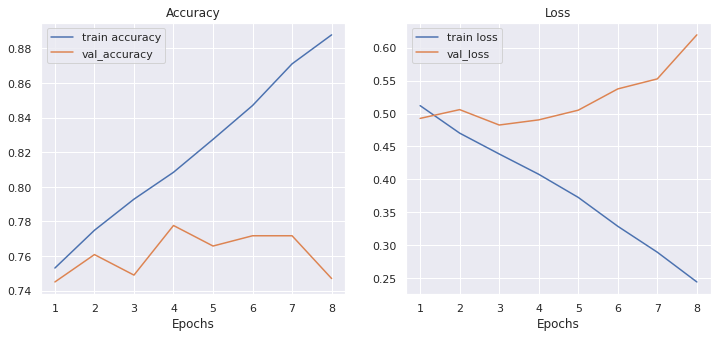

In [34]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, len(history.history['val_accuracy'])+1), 
         history.history['accuracy'], 
         label='train accuracy')
plt.plot(range(1, len(history.history['val_accuracy'])+1), 
         history.history['val_accuracy'], 
         label='val_accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epochs')

plt.subplot(1,2,2)
plt.plot(range(1, len(history.history['val_accuracy'])+1), 
         history.history['loss'], 
         label='train loss')
plt.plot(range(1, len(history.history['val_accuracy'])+1), 
         history.history['val_loss'], 
         label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.title('Loss')
plt.show()



### Evaluate on test set

In [35]:
model.evaluate(X_test_pad, y_test)

24/24 [==============================] - 0s 5ms/step - loss: 0.4985 - accuracy: 0.7573


[0.4984588325023651, 0.7573333382606506]

In [36]:
y_pred = np.where(model.predict(X_test_pad) > .5, 1,0).reshape(1,-1)[0]

In [37]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.87      0.80       418
           1       0.79      0.61      0.69       332

    accuracy                           0.76       750
   macro avg       0.77      0.74      0.75       750
weighted avg       0.76      0.76      0.75       750



In [39]:
cm = confusion_matrix(y_test, y_pred, labels=[0,1])

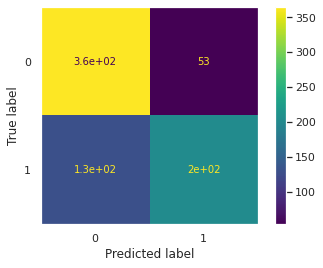

In [40]:
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.grid(None)
plt.show()